The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
{'record_name': '2511400', 'n_sig': 12, 'fs': 500, 'counter_freq': None, 'base_counter': None, 'sig_len': 5000, 'base_time': None, 'base_date': None, 'comments': ['<age>: 58 <sex>: M'], 'sig_name': ['I', 'II', 'III', 'aVR', 'aVF', 'aVL', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'], 'p_signal': array([[-0.02 , -0.04 , -0.02 , ...,  0.   , -0.02 , -0.02 ],
       [-0.02 , -0.02 ,  0.   , ...,  0.015, -0.01 , -0.015],
       [-0.03 , -0.02 ,  0.01 , ...,  0.02 , -0.01 , -0.015],
       ...,
       [-0.015, -0.015,  0.   , ...,  0.06 ,  0.03 ,  0.02 ],
       [-0.015, -0.02 , -0.005, ...,  0.06 ,  0.02 ,  0.02 ],
       [-0.02 , -0.02 ,  0.   , ...,  0.06 ,  0.02 ,  0.02 ]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['2511400.dat', '2511400.dat', '2511400.dat', '2511400.dat', '2511400.dat', '2511400.dat', '2511400.dat', '2511400.dat', '2511400.dat', '2511400.dat', '2511400.dat', '2

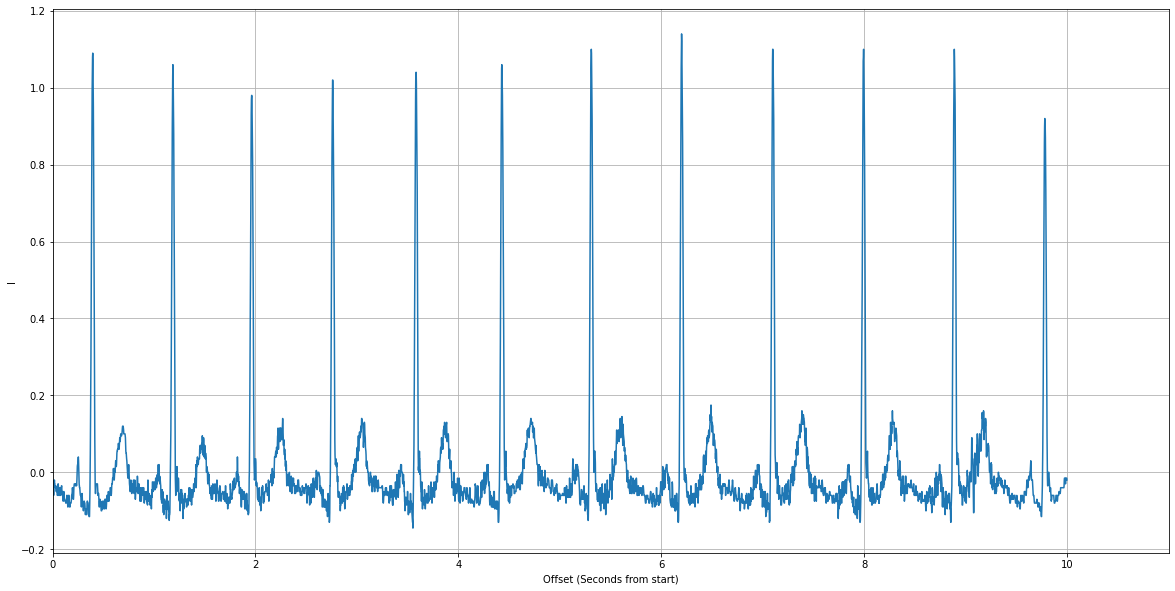

In [5]:
# This code has been adapted from https://github.com/koen-aerts/ECG_ML
%load_ext autoreload
%autoreload 2
import wfdb
import numpy as np
import matplotlib.pyplot as plt


def plot_signal(datfile, SAMPLE_START, SAMPLE_SIZE, CHANNEL, extract_annotation=False):
    record = wfdb.rdrecord(datfile)
    
    # Get data and annotations for the samples selected below.
    SAMPLE_END = SAMPLE_START + SAMPLE_SIZE
    channel = record.p_signal[SAMPLE_START:SAMPLE_END, CHANNEL]

    # Plot the heart beats. Time scale is number of readings divided by sampling frequency.
    times = (np.arange(SAMPLE_START, SAMPLE_END, dtype='float')) / record.fs
    plt.figure(figsize=(20,10))
    plt.plot(times, channel)

    if extract_annotation:
        # Extract annotations.
        annotation = wfdb.rdann(datfile, 'atr')
        
        where = np.logical_and(annotation.sample >= SAMPLE_START, annotation.sample < SAMPLE_END)
        annotation_symbol = np.array(annotation.symbol)[where]
        annotimes = annotation.sample[where] / record.fs

        # Plot the Annotations 
        plt.scatter(annotimes, np.ones_like(annotimes) * channel.max() * 1.4, c='r')
        for idx in range(len(annotimes)):
            plt.annotate(annotation_symbol[idx], xy = (annotimes[idx], channel.max() * 1.3))

    plt.xlim([SAMPLE_START / record.fs, (SAMPLE_END / record.fs) + 1])
    plt.xlabel('Offset (Seconds from start)')
    plt.ylabel(record.sig_name[CHANNEL])
    plt.grid()
    plt.show()


# PICC data directory path
# Read in example signal
data_path='/zfsauton/project/public/chufang/PICC/'
datfile = data_path+'set-a/2511400'
record = wfdb.rdrecord(datfile)
print(record.__dict__)

## Read in annotations
## Mote that there are no annotations for PICC data, but there are for MIT-BIH
# annotation = wfdb.rdann(data_path+'100', extension='atr')
# annotation.__dict__

SAMPLE_START=0   # Start of the sample in the file.
SAMPLE_SIZE=500*10      # Number of readings (500 per second).
CHANNEL=0             # There are 2 channels
plot_signal(datfile, SAMPLE_START, SAMPLE_SIZE, CHANNEL, extract_annotation=False)

In [6]:
from tqdm.notebook import tqdm
import neurokit2 as nk
import numpy as np
import multiprocessing
import sys

sys.path.append('../')
import datasets
import sqis
import featurization


def get_features(channel, sampling_rate=125, window_size=10):
    ## Remove baseline wader and dc offset with highpass Butterworth. Also remove powerline interference (50hz).        
    ecg_cleaned = nk.ecg_clean(channel, sampling_rate=sampling_rate, method="neurokit")

    ## Find peaks indices
    peaks = nk.ecg_peaks(ecg_cleaned, sampling_rate=sampling_rate, method='kalidas2017')[1]['ECG_R_Peaks']

    ## Featurize ecgs
    ecg_features = featurization.featurize_ecg(window=ecg_cleaned, sampling_rate=sampling_rate)
    
    ## Obtain ECG SQIs
    ecg_sqis = sqis.get_ecg_sqis(channel, ecg_cleaned, peaks, sampling_rate, window=window_size)

    return ecg_features + ecg_sqis


X_train, y_train, X_test, y_test = datasets.load_picc(data_path=data_path, verbose=False, train_test_split=.15)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

with multiprocessing.Pool(processes=10) as pool:
    X_train_features = list(tqdm(pool.imap(get_features, X_train), total=len(X_train)))
    X_test_features = list(tqdm(pool.imap(get_features, X_test), total=len(X_test)))


X_train_features = np.array(X_train_features)
X_test_features = np.array(X_test_features)

736it [00:04, 202.41it/s]

(10176, 34) (1800, 34)


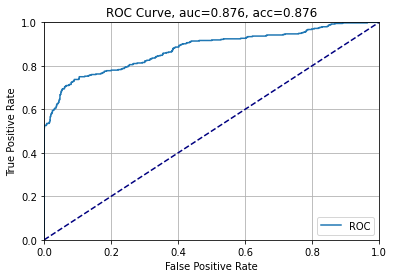

In [ ]:
import sklearn.ensemble

X_train_features_cleaned = np.nan_to_num(X_train_features, nan=0.0, posinf=10000, neginf=-10000)
X_test_features_cleaned = np.nan_to_num(X_test_features, nan=0.0, posinf=10000, neginf=-10000)

model = sklearn.ensemble.RandomForestClassifier(random_state=0, n_estimators=1000, max_depth=5)
print(X_train_features_cleaned.shape, X_test_features_cleaned.shape)
model.fit(X_train_features_cleaned, y_train)

scores = model.predict_proba(X_test_features_cleaned)[:,1]
acc = np.mean(model.predict(X_test_features_cleaned)==y_test)
auc = sklearn.metrics.roc_auc_score(y_test, scores)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, scores, pos_label=1)

plt.plot(fpr, tpr, label='ROC')
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("ROC Curve, auc={0:0.3f}, acc={0:0.3f}".format(auc, acc))
plt.legend(loc="lower right"); plt.grid()

## Note that exact results cannot be reproduced as the official PICC challenge is trained on the entirety of set-a and evaluated on set-b